In [1]:
#import des librairies de base

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split
import pandas as pd

C:\ProgramData\Miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Miniconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\ProgramData\Miniconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#lecture du csv gapfill par pierre et conversion en tableau numpy

price_data = pd.read_csv("../../price_filled2.csv", sep = ";")

tab_price = price_data.to_numpy()[:,3:]
dates_tab = price_data.columns[2:].to_numpy(dtype = np.str)


<ipython-input-2-9dde0a8e7b28>:6: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dates_tab = price_data.columns[2:].to_numpy(dtype = np.str)


In [3]:
# on trouve le premier relevé de chaque mois

current_month = dates_tab[0][:-3]
month_first_index = {current_month : 0}

for i in range(len(dates_tab)) :
    if (dates_tab[i][-4] != current_month[-1]) :
        current_month = dates_tab[i][:-3]
        month_first_index[current_month] = i


In [4]:
# on moyenne les prix sur la durée du mois tous les mois

indexes = np.array(list(month_first_index.values()))
total = []
for i in range(len(month_first_index)-1) :
    X = tab_price[:,indexes[i]:indexes[i+1]].mean(axis = 1)
    total.append(X)
total.append(tab_price[:,indexes[-1]:].mean(axis = 1))
result = np.column_stack(total) # ce tableau contient n_samples samples de n_features prix des features
n_features, n_samples = result.shape

In [9]:
# on lit les valeurs d'IPC données par l'INSEE et on ne garde que les n_samples dernières (en correspondance avec le tableau result)

IPC_df = pd.read_csv("../../valeurs_mensuelles.csv", sep = ";")
dates = IPC_df["Libellé"].to_numpy()[3:]
dates = dates[::-1].copy()

IPC = IPC_df[IPC_df.columns[1]].iloc[3:].to_numpy(dtype = np.float)[::-1]

IPC_selec = IPC[-n_samples:]

<ipython-input-9-56c97438eaec>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  IPC = IPC_df[IPC_df.columns[1]].iloc[3:].to_numpy(dtype = np.float)[::-1]


In [10]:
# on crée trois type de jeux de données (on pourrait faire plus) avec plus ou moins de valeurs passées

X = result.copy()
X0 = np.transpose(X) #juste les données de base
X1 = np.transpose(np.vstack((X[:,1:], IPC_selec[:-1]))) #on donne en plus le point t-1
X2 = np.transpose(np.vstack((np.transpose(X1)[:,1:], IPC_selec[:-2]))) #on donne en plus le point t-2

Y0 = IPC_selec
Y1 = IPC_selec[1:]
Y2 = IPC_selec[2:]



Standardisation : on centre et on réduit

In [12]:
from sklearn.preprocessing import StandardScaler

scaler0 = StandardScaler()
X0_std = scaler0.fit_transform(X0)

# scaler1 = StandardScaler()
# X1_std = scaler1.fit_transform(X1)

# scaler2 = StandardScaler()
# X2_std = scaler2.fit_transform(X2)

LA SECTION QUI VA SUIVRE EST INUTILE POUR L'EXEMPLE, ELLE PERMET JUSTE DE DONNER QUELQUES GRAPHS STYLES PARCE QUE LE GRADIENT BOOSTING CA MARCHE BIEN (même avec des paramètres randoms)

In [13]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X0_std, Y0, test_size = .2) 

ValueError: Found input variables with inconsistent numbers of samples: [89, 377]

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

In [48]:
alpha = 0.9
params = {'n_estimators': 350,
          'max_depth': 6,
          'alpha' : alpha,
          'min_samples_split': 5,
          'learning_rate': 0.1,
          'loss': 'ls'}

In [49]:
reg_up = GradientBoostingRegressor(**params)

reg_up = reg_up.fit(Xtrain, Ytrain)

y_upper_test = reg_up.predict(Xtest)
y_upper_train = reg_up.predict(Xtrain)

reg_low = GradientBoostingRegressor(**params)
reg_low.set_params(alpha = 1-alpha)

reg_low.fit(Xtrain, Ytrain)

y_lower_test = reg_low.predict(Xtest)
y_lower_train = reg_low.predict(Xtrain)

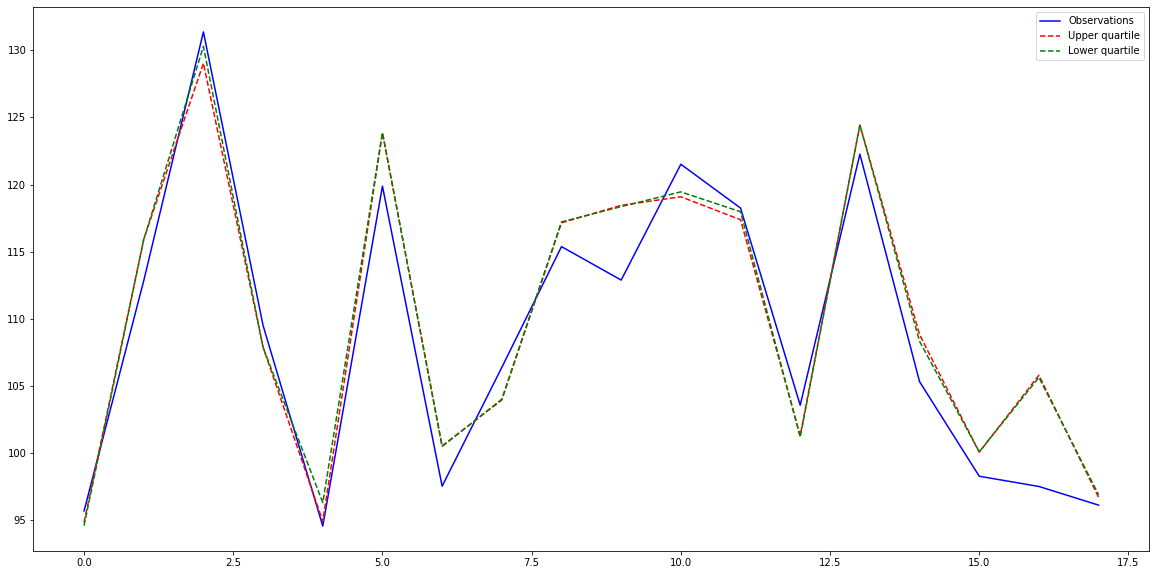

In [50]:
fig = plt.figure(figsize = (20,10))

line3 = plt.plot(Ytest,'b',label=u'Observations')

line1 = plt.plot(y_upper_test, 'r--', label='Upper quartile')
line2 = plt.plot(y_lower_test, 'g--',label='Lower quartile')


# plt.fill_between(range(0,len(y_upper_train)),y_upper_train, y_lower_train, alpha =0.1)

plt.legend()
# plt.xlim(50,60)

plt.show()

RETOUR DANS CE QUI NOUS INTERESSE ICI

In [51]:
# les liste des paramètres que vous voulez tester (bien sur il faut mettre plus de trucs dedans mais ca dépend de votre probleme)
n_list = [350]
depth_list = [6]
mins_list = [5]
lr_list = [.01, .1]

In [52]:
# on déclare le modèle qu'on veut tester
from sklearn.ensemble import GradientBoostingRegressor

grad = GradientBoostingRegressor(alpha = .5, loss = 'ls') # la déclaration des hyper paramètres constants doit se faire ici

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
 
tuned_parameters = [{'n_estimators': n_list,
                      'max_depth': depth_list,
                      'min_samples_split': mins_list,
                      'learning_rate': lr_list}]
nb_folds = 5
grid = GridSearchCV(grad, tuned_parameters, cv=nb_folds, scoring=make_scorer(mean_squared_error))

grid.fit(X1, Y1) # attention : il faudra répéter l'étape pour X0, X2 et d'autres jeux de données si vous voulez 

scores = grid.cv_results_['mean_test_score'] 

In [ ]:
scores 
# attention : pour des raisons de classement les MSE sont ici données négatives 
#(des bails de celle qui est la plus grande est la meilleure pour 
#le programme mais la vraie MSE serait donc celle la plus proche de 0)

Ici on a fait le plus gros, reste à faire deux choses : sauvegarder les résultats du test et surtout : faire tourner le test sur beaucoup plus de variables, si vous l'avez fait tourner sur votre pc vous aurez remarqué que c'est ultra long. Pour accélerer les choses si vous bossez sur des modèles compliqués go sous google collab où vous pourrez faire tourner votre programme pendant 1h30 sans y toucher, il faudra juste venir tous les $90min- \varepsilon$ pour vous montrer à google que vous l'avez pas oublié.
Pour les imports de tableau sous google collab, mettez `price_filled2.csv` et `valeurs_mensuelles.csv` sur votre drive perso puis ajoutez en haut du notebook : 

`from google.colab import drive
drive.mount('/content/gdrive')`

suivez les instructions en executant la case puis remplacez les chemins d'accès aux deux fichiers dans les blocs au début du notebook par `'/content/gdrive/My Drive/[chemin vers le dossier dans votre drive]`

Enfin executez le bloc si dessous pour sauvegarder vos données de test

In [ ]:
 df = pd.DataFrame(grid.cv_results_)

 df.to_csv('/content/gdrive/My Drive/result.csv')